# Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов и задачу классификации изображений.__

## Part 4. HAR classification with raw data
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [68]:
import torch
import torch.nn as nn
from torch.utils.data import Subset, Dataset, TensorDataset, DataLoader, random_split
from pytorch_model_summary import summary

In [3]:
from tqdm.notebook import tqdm

In [4]:
from PIL import Image
from torchvision.transforms import v2

In [5]:
from IPython.display import clear_output

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

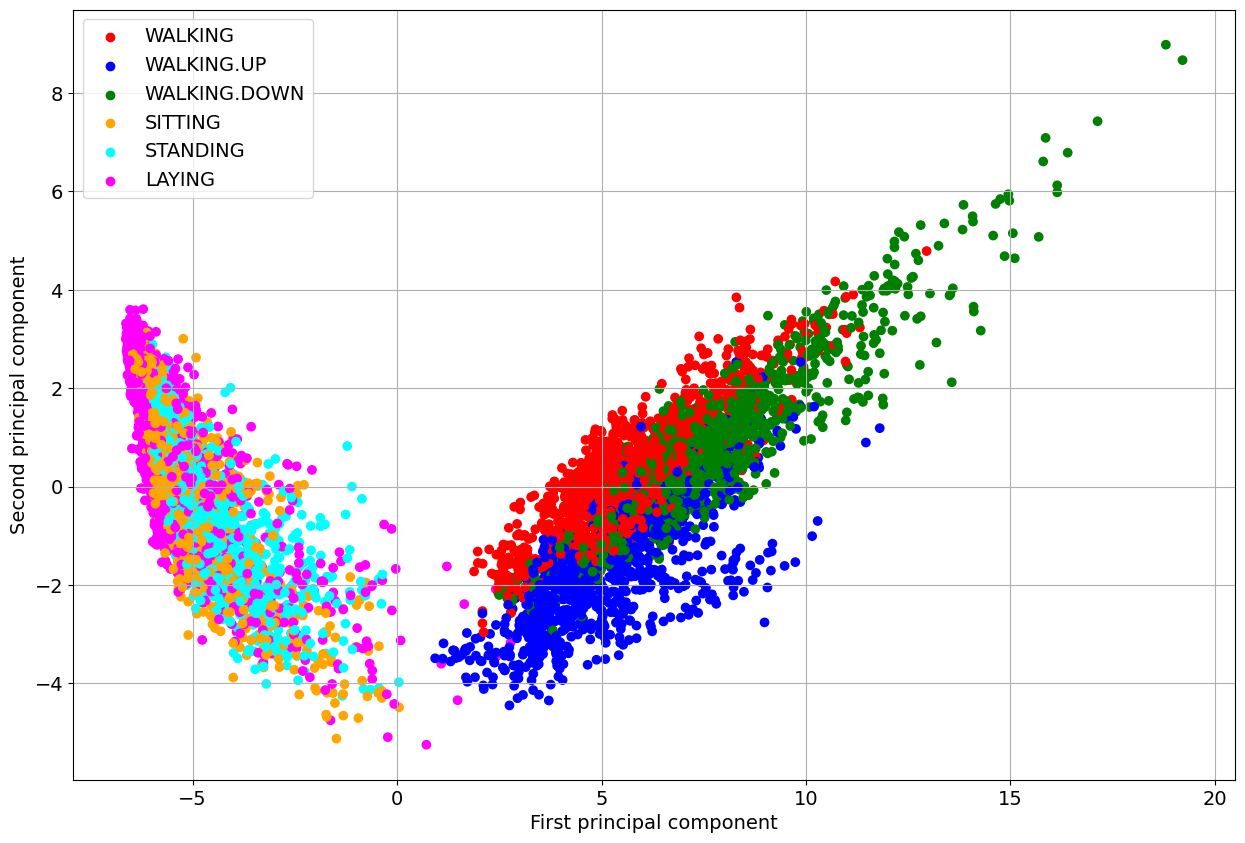

In [154]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [155]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [156]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [157]:
np.unique(y_test), X_train.dtype

(array([0, 1, 2, 3, 4, 5], dtype=int32), dtype('float32'))

In [158]:
list(map(type, [X_train, X_test, y_train, y_test]))

[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]

#### Построение сети и эксперименты

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__

##### LSTM

Так как в задаче используются последовательные во времени данные, то будет разумно попробовать решить задачу с помощью LSTM.  
Буду использовать библиотеку PyTorch.

In [159]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64).reshape(-1)
y_test = torch.tensor(y_test, dtype=torch.int64).reshape(-1)

In [160]:
# y_train = nn.functional.one_hot(y_train.reshape(-1), num_classes=6)
# y_test = nn.functional.one_hot(y_test.reshape(-1), num_classes=6)

In [161]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [162]:
rand_gen = torch.Generator().manual_seed(42)
train_dataset, valid_dataset = random_split(train_dataset, [0.9, 0.1], rand_gen)

In [163]:
list(map(len, [train_dataset, valid_dataset, test_dataset]))

[6617, 735, 2947]

In [164]:
params = {
    'batch_size': 64,
    'seq_len': 128,
    'n_channels': 9,
    'hidden_size': 64,
    'num_layers': 3,
    'dropout': 0.25,
    'n_classes': 6
}

In [170]:
train_loader = DataLoader(train_dataset, params['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, params['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, params['batch_size'], shuffle=False)

In [171]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=params['n_channels'],
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            batch_first=True,
            dropout=params['dropout']
        )
        self.linear = nn.Linear(
            params['hidden_size'],
            params['n_classes']
        )
        
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        logits = self.linear(h[-1])
        return logits

In [172]:
model = LSTM()
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

In [173]:
print(summary(model, torch.zeros((params['batch_size'], params['seq_len'], params['n_channels']))))

-----------------------------------------------------------------------------------------------
      Layer (type)                                Output Shape         Param #     Tr. Param #
            LSTM-1     [64, 128, 64], [3, 64, 64], [3, 64, 64]          85,760          85,760
          Linear-2                                     [64, 6]             390             390
Total params: 86,150
Trainable params: 86,150
Non-trainable params: 0
-----------------------------------------------------------------------------------------------


In [169]:
# features, targets = next(iter(train_loader))
# logits = model(features)
# print(logits.size(), targets.size())
# loss = loss_func(logits, targets)
# print(loss)
# loss.backward()

torch.Size([64, 6]) torch.Size([64])
tensor(1.7963, grad_fn=<NllLossBackward0>)


In [182]:
loss_history = {
    'train': [],
    'valid': []
}

In [183]:
best_model_params = {
    'valid_loss': float('inf'),
    'epoch': -1
}

In [184]:
def save_checkpoint(model, optimizer, epoch, loss_history, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_history
    }
    torch.save(checkpoint, path)

In [185]:
def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss_history = checkpoint['loss_history']
    return epoch, loss_history

In [192]:
def train(model, n_epochs, loss_history, train_loader, valid_loader, best_model_params):
    for epoch in range(n_epochs):
        model.train()
        train_loss_batches = []
        train_loader_tqdm = tqdm(train_loader, 
                                desc=f"Epoch {epoch + 1}/{n_epochs} - Training",
                                leave=False)
        for features, targets in train_loader_tqdm:
            logits = model(features)
            loss = loss_func(logits, targets)
            train_loss_batches.append(loss.detach().cpu().numpy() * features.size()[0])
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_epoch_loss = sum(train_loss_batches) / len(train_dataset)
        loss_history['train'].append(train_epoch_loss)
        
        model.eval()
        valid_loss_batches = []
        valid_loader_tqdm = tqdm(valid_loader,
                                 desc=f"Epoch {epoch + 1}/{n_epochs} - Validation",
                                 leave=False)
        with torch.no_grad():
            for features, targets in valid_loader_tqdm:
                logits = model(features)
                loss = loss_func(logits, targets)
                valid_loss_batches.append(loss.detach().cpu().numpy() * features.size()[0])
            valid_epoch_loss = sum(valid_loss_batches) / len(valid_dataset)
            loss_history['valid'].append(valid_epoch_loss)
            
        if sum(valid_loss_batches) / len(valid_dataset) < best_model_params['valid_loss']:
            best_model_params['valid_loss'] = sum(valid_loss_batches) / len(valid_dataset)
            save_checkpoint(model, opt, epoch + 1, loss_history, 'models_part4/best_lstm_1.pth')
        
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        
        plt.plot(loss_history['train'], label='Train Loss')
        plt.plot(loss_history['valid'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Loss - Epoch {epoch + 1}/{n_epochs}')
        plt.legend()
        plt.grid(True)

        plt.show()

        print(f"Epoch {epoch + 1}/{n_epochs}: "
            f"Train Loss = {train_epoch_loss:.3f}, Validation Loss = {valid_epoch_loss:.3f}")

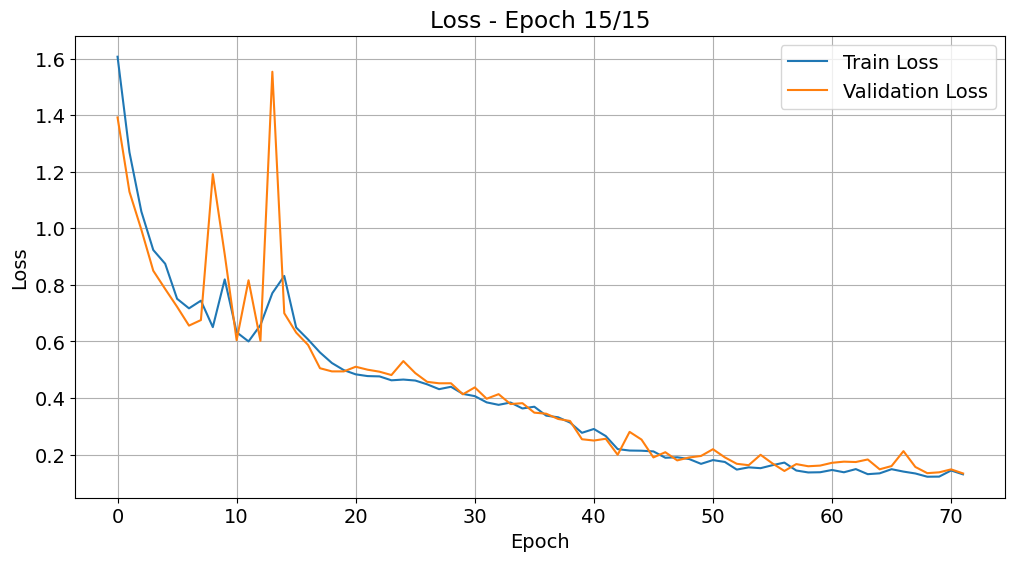

Epoch 15/15: Train Loss = 0.130, Validation Loss = 0.133


In [199]:
train(model=model, 
      n_epochs=15,
      loss_history=loss_history,
      train_loader=train_loader,
      valid_loader=valid_loader,
      best_model_params=best_model_params)

In [195]:
def test(model, test_loader):
    sm = nn.Softmax(dim=1)
    model.eval()
    corr_preds = 0
    total_preds = 0
    test_loader_tqdm = tqdm(test_loader, 
                            desc='Testing',
                            leave=False)    
    with torch.no_grad():
        for features, targets in test_loader_tqdm:
            logits = model(features)
            probs = sm(logits)
            _, pred_labels = torch.max(probs, dim=1)
            corr_preds += (pred_labels == targets).sum().item()
            total_preds += targets.size(0)
    
    acc = corr_preds / total_preds
    print(f"Test Accuracy: {acc * 100:.3f}%")

In [200]:
test(model=model, test_loader=test_loader)

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Test Accuracy: 90.872%


## Part 5. Dogs classification
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/vision/stable/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку.

Требуется добиться accuracy > 93%

In PyTorch we have such models:
* AlexNet
* ConvNeXt
* DenseNet
* EfficientNet
* EfficientNetV2
* GoogLeNet
* Inception V3
* MaxVit
* MNASNet
* MobileNet V2
* MobileNet V3
* RegNet
* ResNet
* ResNeXt
* ShuffleNet V2
* SqueezeNet
* SwinTransformer
* VGG
* VisionTransformer
* Wide ResNet

Determining the "best" model from the list depends on various factors, including the specific task, dataset, computational resources, and performance criteria (e.g., accuracy, inference speed, model size). General comparison of these models:

1. **State-of-the-Art Performance**:
   - **SwinTransformer** and **VisionTransformer (ViT)**: These models represent the latest advancements in computer vision, leveraging Transformer architectures, which have proven to be powerful for various vision tasks. SwinTransformer, in particular, has achieved state-of-the-art results in many benchmarks, outperforming many traditional CNNs.

2. **Efficiency and Scalability**:
   - **EfficientNet** and **EfficientNetV2**: EfficientNet models are designed to achieve high accuracy while being highly efficient in terms of parameter count and computational cost. EfficientNetV2 further improves on EfficientNet with faster training times and better performance.
   - **ConvNeXt**: This model combines the strengths of modern CNNs with techniques from Transformer models, offering a good balance between efficiency and performance.

3. **Legacy Models with Strong Performance**:
   - **ResNet** and **ResNeXt**: ResNet (especially deeper versions like ResNet-50, ResNet-101) has been a cornerstone in deep learning, introducing residual connections that made training very deep networks feasible. ResNeXt builds on ResNet by introducing cardinality (the number of independent paths) to improve accuracy.
   - **Inception V3** and **GoogLeNet**: These models introduced innovative architectural concepts like Inception modules, which allow the network to learn from multi-scale features. Inception V3 is particularly well-known for its strong performance on various benchmarks.

4. **Lightweight Models for Mobile/Edge Applications**:
   - **MobileNet V2, V3**: These models are designed for resource-constrained environments, offering a good trade-off between accuracy and model size.
   - **ShuffleNet V2** and **MNASNet**: Similar to MobileNet, these models are optimized for speed and efficiency, making them suitable for mobile and edge devices.

5. **Other Considerations**:
   - **MaxVit**: A relatively newer model that combines convolutions with Vision Transformer blocks, potentially offering strong performance with a balanced architecture.
   - **DenseNet**: Known for its dense connectivity pattern, DenseNet can achieve competitive accuracy with fewer parameters by promoting feature reuse.
   - **VGG**: One of the earlier models that established deep CNN architectures, but now considered less efficient compared to newer models due to its large parameter count.
   - **SqueezeNet**: An extremely lightweight model, designed to be efficient with fewer parameters, making it suitable for very constrained environments.

Summary:

- **Best for Accuracy/Performance**: **SwinTransformer**, **VisionTransformer (ViT)**, **EfficientNetV2**, **ConvNeXt**
- **Best for Efficiency (Mobile/Edge)**: **MobileNet V2/V3**, **EfficientNet**, **ShuffleNet V2**
- **Best for General Use**: **ResNet**, **DenseNet**

If you have access to substantial computational resources and are working on large-scale tasks, **SwinTransformer** or **VisionTransformer** models would likely give you the best performance. If efficiency is a priority, especially for deployment on mobile devices, **EfficientNetV2** or **MobileNet V3** are excellent choices. For a balance of performance, efficiency, and ease of use, **ResNet** models are still a strong go-to option.

### Notes about task

#### Model
Задача предсказания класса изображения, лучше всего использовать архитектуру моделей на сверточных нейронных сетях.  
Буду использовать предобученную модель EfficientNetV2-S и MobileNetV3.  
По идее, просто изменю последний слой на линейный слой с 50 выходами.  

#### Data
Создать PyTorch Dataset для моих данных и DataLoader, чтобы он эффективно подгружал данные в модель. Использовать пайплайны обработки изображений, чтобы потом (если будет недостаточная эффективность модели) добавить туда аугментацию.  
Не забыть нормально разделить датасет на выборки - использовать stratified разделение, чтобы сохранить распределение классов во всех выборках.  
Изучить распределение классов.

#### Loss and metrics
Функция потерь - CrossEntropyLoss.  
Метрики: accuracy, confusion matrix, F1-score (with averaging)

### Parameters

In [136]:
N_CLASSES = 50
BATCH_SIZE = 64

### Data

We can use the PyTorch `ImageFolder` class (it is doing exaclty the same as below)

In [137]:
class DogBreedsDataset(Dataset):
    """Dog breeds dataset for multi-class classification."""
    
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with images, each class in separate folder.
            transform (callable, optional): Optional transform to be applied on a sample. 
                Defaults to None.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(self.root_dir)
        
        # create the list of image paths and corresponding labels
        self.image_paths = list()
        self.labels = list()
        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if os.path.isfile(img_path):
                        self.image_paths.append(img_path)
                        self.labels.append(idx)
        
    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.labels)
    
    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            sample (dict): A dictionary containing the image and the label.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        sample = {'image': image, 'label': label}
        
        return sample

In [138]:
dog_breeds_dataset = DogBreedsDataset('part5_dataset/train')

In [139]:
dog_breeds_dataset[0]

{'image': <PIL.Image.Image image mode=RGB size=259x500>, 'label': 0}

In [140]:
len(dog_breeds_dataset)

7166

In [141]:
np.bincount(dog_breeds_dataset.labels)

array([155, 195, 154, 151, 129, 137, 169, 252, 123, 143, 133, 124, 125,
       137, 124, 128, 197, 126, 129, 148, 139, 122, 123, 122, 144, 138,
       122, 139, 139, 124, 120, 165, 125, 128, 124, 174, 125, 174, 123,
       161, 129, 151, 126, 176, 155, 142, 170, 131, 153, 123])

In [142]:
def sample_random_images(dataset, num_samples=5):
    unique_classes = list(set(dataset.labels))
    sampled_classes = np.random.choice(unique_classes, 
                                       min(num_samples, len(unique_classes)), 
                                       replace=False)
    
    images = []
    labels = []

    for class_idx in sampled_classes:
        class_image_indices = [i for i, label in enumerate(dataset.labels) if label == class_idx]
        sampled_index = np.random.choice(class_image_indices)
        
        sample = dataset[sampled_index]
        images.append(sample['image'])
        labels.append(sample['label'])
        
    return images, labels

In [143]:
def show_images(images, labels, class_names):
    plt.figure(figsize=(16, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(v2.ToPILImage()(images[i]))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

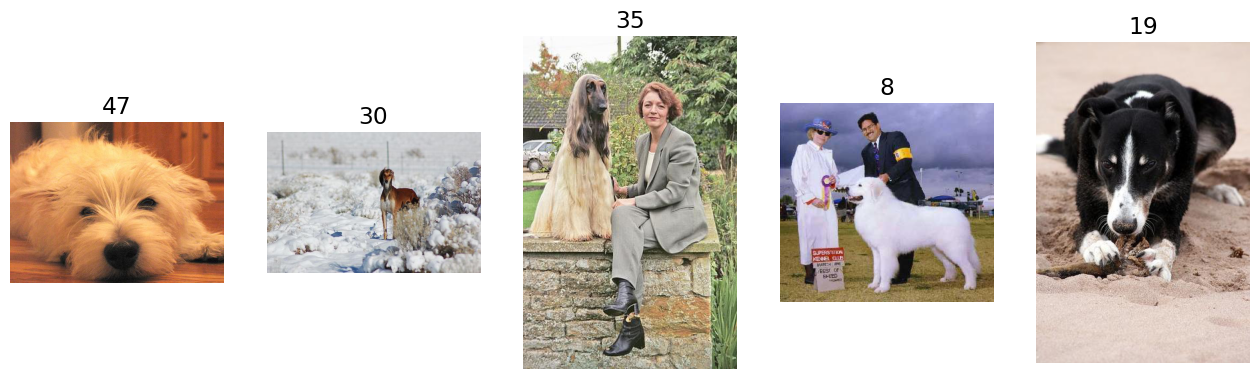

In [144]:
images, labels = sample_random_images(dog_breeds_dataset, num_samples=5)
class_names = dog_breeds_dataset.classes

show_images(images, labels, class_names)

### EfficientNet-V2-S

In [29]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from pytorch_model_summary import summary

In [16]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /home/den/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:04<00:00, 21.6MB/s]


In [32]:
print(summary(model, torch.zeros((128, 3, 100, 100))))

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
               Conv2d-1     [128, 24, 50, 50]             648             648
          BatchNorm2d-2     [128, 24, 50, 50]              48              48
                 SiLU-3     [128, 24, 50, 50]               0               0
          FusedMBConv-4     [128, 24, 50, 50]           5,232           5,232
          FusedMBConv-5     [128, 24, 50, 50]           5,232           5,232
          FusedMBConv-6     [128, 48, 25, 25]          25,632          25,632
          FusedMBConv-7     [128, 48, 25, 25]          92,640          92,640
          FusedMBConv-8     [128, 48, 25, 25]          92,640          92,640
          FusedMBConv-9     [128, 48, 25, 25]          92,640          92,640
         FusedMBConv-10     [128, 64, 13, 13]          95,744          95,744
         FusedMBConv-11     [128, 64, 13, 13]         164,480  

In [33]:
for param in model.parameters():
    param.requires_grad = False

In [34]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [41]:
model.classifier[1].in_features

1280

In [39]:
model.classifier[1] = nn.Linear(model.classifier[1].in_features, N_CLASSES)

In [43]:
print(summary(model, torch.zeros((128, 3, 100, 100))))

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
               Conv2d-1     [128, 24, 50, 50]             648               0
          BatchNorm2d-2     [128, 24, 50, 50]              48               0
                 SiLU-3     [128, 24, 50, 50]               0               0
          FusedMBConv-4     [128, 24, 50, 50]           5,232               0
          FusedMBConv-5     [128, 24, 50, 50]           5,232               0
          FusedMBConv-6     [128, 48, 25, 25]          25,632               0
          FusedMBConv-7     [128, 48, 25, 25]          92,640               0
          FusedMBConv-8     [128, 48, 25, 25]          92,640               0
          FusedMBConv-9     [128, 48, 25, 25]          92,640               0
         FusedMBConv-10     [128, 64, 13, 13]          95,744               0
         FusedMBConv-11     [128, 64, 13, 13]         164,480  

In [44]:
preprocess = weights.transforms()

In [45]:
preprocess, preprocess.describe()

(ImageClassification(
     crop_size=[384]
     resize_size=[384]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ),
 'Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[384]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[384]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.')

### MobileNet-V3-Large

In [145]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

In [146]:
weights = MobileNet_V3_Large_Weights.DEFAULT
model = mobilenet_v3_large(weights=weights)

In [147]:
for param in model.parameters():
    param.requires_grad = False

In [148]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [149]:
model.classifier[3] = nn.Linear(model.classifier[3].in_features, N_CLASSES)

In [150]:
preprocess = weights.transforms()
preprocess, preprocess.describe()

(ImageClassification(
     crop_size=[224]
     resize_size=[232]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ),
 'Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[232]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.')

In [151]:
print(summary(model, torch.zeros(128, 3, 100, 100)))

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
               Conv2d-1     [128, 16, 50, 50]             432               0
          BatchNorm2d-2     [128, 16, 50, 50]              32               0
            Hardswish-3     [128, 16, 50, 50]               0               0
     InvertedResidual-4     [128, 16, 50, 50]             464               0
     InvertedResidual-5     [128, 24, 25, 25]           3,440               0
     InvertedResidual-6     [128, 24, 25, 25]           4,440               0
     InvertedResidual-7     [128, 40, 13, 13]          10,328               0
     InvertedResidual-8     [128, 40, 13, 13]          20,992               0
     InvertedResidual-9     [128, 40, 13, 13]          20,992               0
    InvertedResidual-10       [128, 80, 7, 7]          32,080               0
    InvertedResidual-11       [128, 80, 7, 7]          34,760  

### Preprocessing pipeline

In [183]:
data_transforms = {
    'train': v2.Compose([
        # maybe augmentation...
        
        # convert to torch tensor
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        # model preprocessing
        preprocess
    ]),
    'valid': v2.Compose([
        # convert to torch tensor
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        # model preprocessing
        preprocess
    ])
}

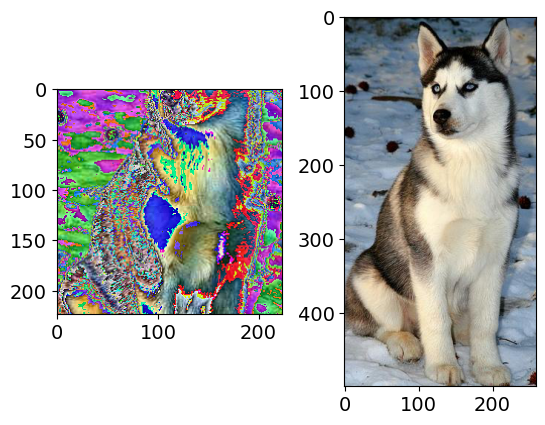

In [184]:
img = data_transforms['train'](dog_breeds_dataset[0]['image'])
plt.subplot(1, 2, 1)
plt.imshow(v2.ToPILImage()(img))
plt.subplot(1, 2, 2)
plt.imshow(dog_breeds_dataset[0]['image'])

### Dataset and Dataloaders

In [185]:
from collections import defaultdict

In [186]:
def stratified_split_indices(labels, train_size=0.8, seed=42):
    """Splits indices into train and validation subsets."""
    # Organize indices by label
    label_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        label_to_indices[label].append(idx)
        
    np.random.seed(seed)
    
    train_ids = []
    valid_ids = []
    
    for label, ids in label_to_indices.items():
        np.random.shuffle(ids)
        split_point = round(len(ids) * train_size)
        train_ids.extend(ids[:split_point])
        valid_ids.extend(ids[split_point:])
        
    np.random.shuffle(train_ids)
    np.random.shuffle(valid_ids)
    
    return train_ids, valid_ids

In [187]:
train_ids, valid_ids = stratified_split_indices(dog_breeds_dataset.labels, train_size=0.8, seed=42)

In [188]:
train_dataset = Subset(dog_breeds_dataset, train_ids)
valid_dataset = Subset(dog_breeds_dataset, valid_ids)

In [189]:
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, index):
        # Get the data and label from the original subset
        data = self.subset[index]
        image, label = data['image'], data['label']
        
        # Apply transform if provided
        if self.transform:
            image = self.transform(image)
        
        return {'image': image, 'label': label}
    
    def __len__(self):
        return len(self.subset)

In [190]:
train_dataset = TransformedDataset(train_dataset, transform=data_transforms['train'])
valid_dataset = TransformedDataset(valid_dataset, transform=data_transforms['valid'])

In [191]:
list(map(len, [train_dataset, valid_dataset, dog_breeds_dataset]))

[5730, 1436, 7166]

In [192]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, BATCH_SIZE, shuffle=False)

### Creating optimizer

In [193]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)

classifier.3.weight
classifier.3.bias


In [194]:
optimizer = torch.optim.Adam(params_to_update, lr=3e-4)

### Loss function

In [195]:
loss_func = nn.CrossEntropyLoss()

### Training

In [203]:
loss_history = {
    'train': [],
    'valid': []
}

In [204]:
val_acc_hist = list()

In [205]:
# we will be saving only params of the trained FC layer and optim state for this layer
best_model_params = {
    'valid_loss': float('inf'),
    'epoch': -1
}

In [210]:
def save_only_trainable_checkpoint(model, optimizer, epoch, loss_history, path):
    trainable_state_dict = {
        name: param for name, param in model.named_parameters() if param.requires_grad
    }
    checkpoint = {
        'epoch': epoch,
        'trainable_state_dict': trainable_state_dict,
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_history
    }
    torch.save(checkpoint, path)

In [211]:
def load_only_trainable_checkpoint(model, potimizer, path):
    checkpoint = torch.load(path)
    
    model_state_dict = model.state_dict()
    model_state_dict.update(checkpoint['trainable_state_dict'])
    model.load_state_dict(model_state_dict)
    
    epoch = checkpoint['epoch']
    loss_history = checkpoint['loss_history']
    
    return epoch, loss_history

In [212]:
def train(model, opt, n_epochs, loss_history, train_loader, valid_loader, best_model_params):
    for epoch in range(n_epochs):
        model.train()
        train_loss_batches = []
        train_loader_tqdm = tqdm(train_loader, 
                                desc=f"Epoch {epoch + 1}/{n_epochs} - Training",
                                leave=False)
        for batch in train_loader_tqdm:
            features = batch['image']
            targets = batch['label']
            logits = model(features)
            loss = loss_func(logits, targets)
            train_loss_batches.append(loss.detach().cpu().numpy() * features.size()[0])
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_epoch_loss = sum(train_loss_batches) / len(train_dataset)
        loss_history['train'].append(train_epoch_loss)
        
        model.eval()
        valid_loss_batches = []
        correct = 0
        total = 0
        
        valid_loader_tqdm = tqdm(valid_loader,
                                 desc=f"Epoch {epoch + 1}/{n_epochs} - Validation",
                                 leave=False)
        with torch.no_grad():
            for batch in valid_loader_tqdm:
                features = batch['image']
                targets = batch['label']
                logits = model(features)
                loss = loss_func(logits, targets)
                valid_loss_batches.append(loss.detach().cpu().numpy() * features.size()[0])
                
                preds = torch.argmax(logits, dim=1)
                correct += (preds == targets).sum().item()
                total += targets.size(0)

            valid_epoch_loss = sum(valid_loss_batches) / len(valid_dataset)
            loss_history['valid'].append(valid_epoch_loss)
            
            val_acc_hist.append(correct / total)

            
        if valid_epoch_loss < best_model_params['valid_loss']:
            best_model_params['valid_loss'] = valid_epoch_loss
            save_only_trainable_checkpoint(model, 
                                           opt, 
                                           epoch + 1, 
                                           loss_history, 
                                           'models_part5/best_mobilenet3-l.pth')
        
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(loss_history['train'], label='Train Loss')
        plt.plot(loss_history['valid'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Loss - Epoch {epoch + 1}/{n_epochs}')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(val_acc_hist, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f'Validation Accuracy - Epoch {epoch + 1}/{n_epochs}')
        plt.legend()
        plt.grid(True)
        
        plt.show()

        print(f"Epoch {epoch + 1}/{n_epochs}: "
              f"Train Loss = {train_epoch_loss:.3f}, Validation Loss = {valid_epoch_loss:.3f}, "
              f"Validation Accuracy = {val_acc_hist[-1]:.3f}")

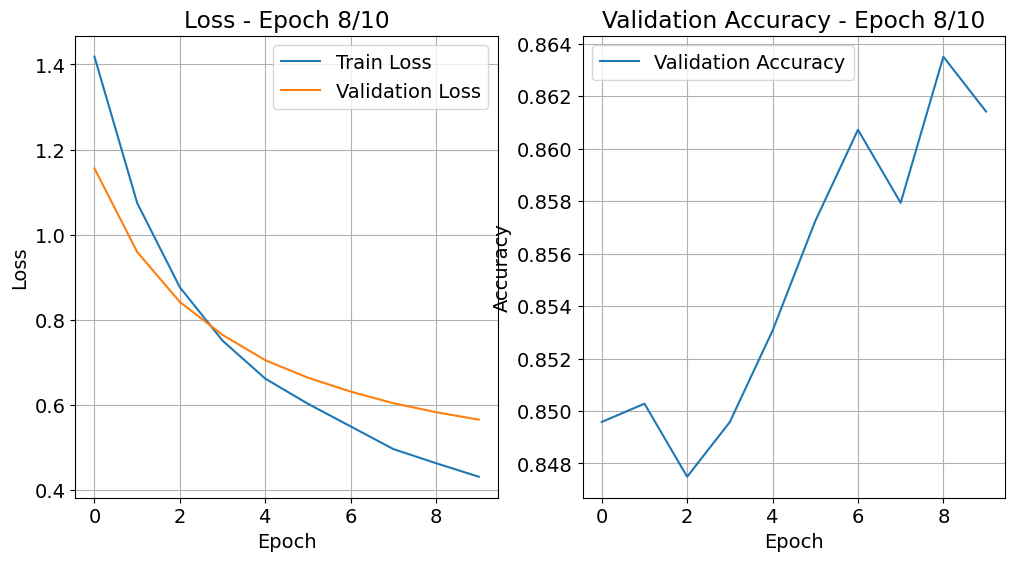

Epoch 8/10: Train Loss = 0.431, Validation Loss = 0.566, Validation Accuracy = 0.861


Epoch 9/10 - Training:   0%|          | 0/90 [00:00<?, ?it/s]

In [214]:
train(model=model, 
      opt=optimizer,
      n_epochs=10,
      loss_history=loss_history,
      train_loader=train_loader,
      valid_loader=valid_loader,
      best_model_params=best_model_params)